In [ ]:
import requests
import pandas as pd
import os
from datetime import datetime


# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
class CryptoCompareWrapper(object):
    __DEFAULT_URL = 'https://min-api.cryptocompare.com/data/'
    __DEFAULT_COIN = 'BTC'
    __DEFAULT_CURRENCY = 'USD'

    def __init__(self, url=__DEFAULT_URL, coin=__DEFAULT_COIN, currency=__DEFAULT_CURRENCY):
        self.base_url = url
        self.base_coin = coin
        self.base_currency = currency
    def coinList(self):
        """
        Returns general info about all of the coins on the website.
        """
        coin_list_URL = 'https://www.cryptocompare.com/api/data/coinlist/'
        r = requests.get(coin_list_URL)
        return r.json()

    def ohlcv(self, **params):
        """
        Returns the price of the specified coin in terms of whichever
        currency is specified.
        Optional parameters:
            (string) fsym - from symbol
            (string) tsyms - to symbols, include multiple symbols
            (string) e - name of exchange. Default: CCCAGG
            (string) extraParams - Name of your application
            (numeric) aggregate - Time period to aggregate the data over (for daily it's days, for hourly it's hours and for minute histo it's minutes)
            (numeric) toTs - Last unix timestamp to return data for
            (bool) sign - If set to true, the server will sign the requests
            (numeric) end_time - keeps searching for this time stamp.
        """
        url = self.base_url + 'histohour'
        df = pd.DataFrame()
        while params['toTs'] > params['end_time']:
            for coins in params['fsym']:
                params2 = params
                params2['fsym'] = coins
                r = requests.get(url, params2)
                r_json = r.json()
                df0 = pd.DataFrame(r_json['Data'])
                df0['coin'] = coins
                df = pd.concat([df, df0], axis = 0)
            params['toTs'] = df['time'].min()
        return df

"^^^Might want to go back and remove duplicate records (seems like there will be some overlap)"    
C = CryptoCompareWrapper()

test = {
        'fsym' : ['BTC', 'ETH', 'XRP', 'EOS', 'XLM', 'DOGE'], # from symbol
        'tsym' : 'USD', # to symbol (include multiple symbols)
        'e' : 'CCCAGG', # name of exhange
        'extraParams' : 'RandomCutAnomalyDetector', # name of your application
        'sign' : False, # if true - server will sign requests
        'aggregate' : 300000, # if false, will get values w/out using any conversion
        'toTs' : 1537746846,
        'end_time' : 1420070400
}


crypto_ohlcv = C.ohlcv(**(test))
crypto_ohlcv['time'] = pd.to_datetime(crypto_ohlcv['time'], unit='s')
#df = pd.DataFrame(crypto_ohlcv['Data'])
#df['coin'] = 'BTC'
#print(df.dtypes)
crypto_ohlcv.head()
#create new repo for crypto-project and place the Jupyter Notebook in it
#os.mkdir('/home/ubuntu/crypto-project')
#!mv /home/ubuntu/random-cut-forest.ipynb /home/ubuntu/crypto-project

#url for obtaining minute-by-minute Bitcoin OHTV data from the Bitfinex exchange



In [ ]:
crypto_ohlcv.shape()

In [ ]:
crypto_pivot = crypto_ohlcv.pivot(index ='time', columns ='coin')
crypto_df = pd.DataFrame(crypto_pivot.to_records())
crypto_df.head()
#print("Earliest timestamp:" + crypto_ohlcv.groupby('coin')['time'].min())
#print("Latest timestamp:" + crypto_ohlcv.groupby('coin')['time'].max())

In [17]:
import boto3

bucket = 'ads-bucket-senichol'
prefix = 'crypto-compare-data'
# create the csv files on local disc to upload to S3
crypto_df.to_csv('crypto_df.csv', index=False, header=False)

# upload the files to S3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'crypto_df.csv')).upload_file('crypto_df.csv')


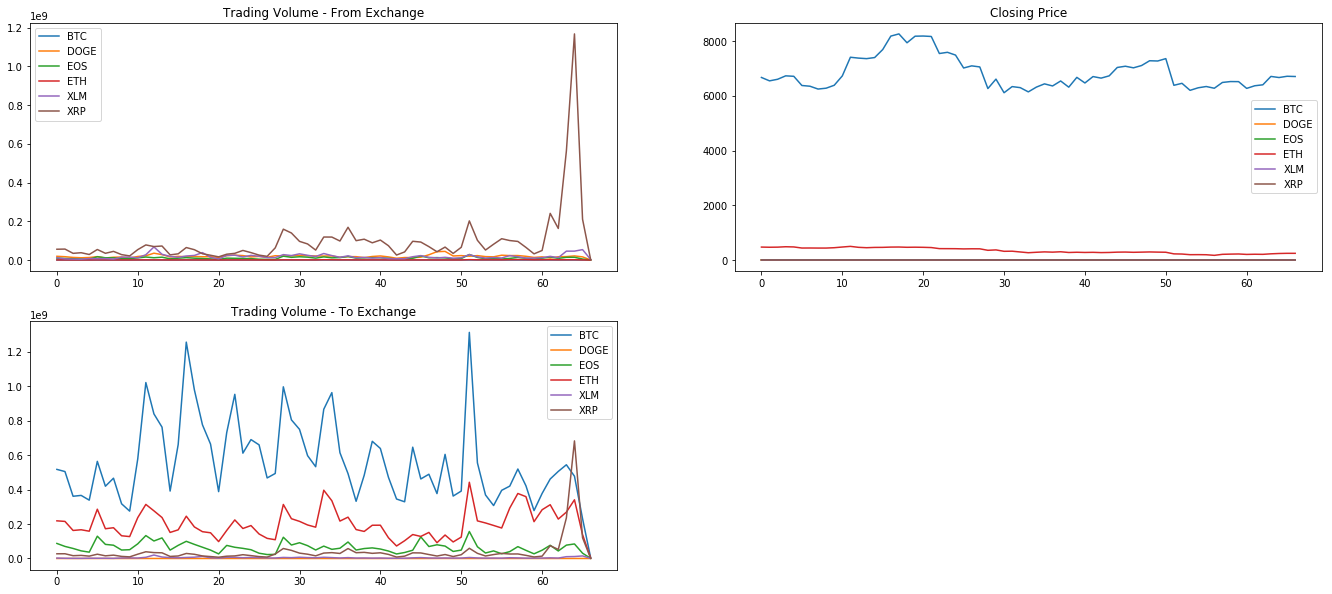

In [5]:
import matplotlib.pyplot as plt




plt.subplot(221)
crypto_ohlcv.groupby('coin')['volumefrom'].plot(legend=True)
plt.title('Trading Volume - From Exchange')

plt.subplot(222)
crypto_ohlcv.groupby('coin')['close'].plot(legend=True)
plt.title('Closing Price')

plt.subplot(223)
crypto_ohlcv.groupby('coin')['volumeto'].plot(legend=True)
plt.title('Trading Volume - To Exchange')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


In [8]:
#Random Cut Forest reference from AWS (contains good tips re: model training inputs)
#https://aws.amazon.com/blogs/machine-learning/use-the-built-in-amazon-sagemaker-random-cut-forest-algorithm-for-anomaly-detection/


# creates a .pbr file and stores in the s3 bucket
def convert_and_upload_training_data(
    ndarray, bucket, prefix, filename='btcdata9-9.pbr'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer

    # convert Numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)

    # upload to S3
    s3_object = os.path.join(prefix, 'train', filename)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

bucket = 'ads-bucket-senichol' # <-- use your own bucket here
prefix = 'sagemaker/randomcutforest' # <-- label your own file directory
s3_train_data = convert_and_upload_training_data(
    btc.as_matrix().reshape(-1,1), # <-- you can subset the data: e.g. btc.volumeto.as_matris().reshape(-1,1),
    bucket,
    prefix)

In [63]:
import boto3
import sagemaker
containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = 'us-east-2'
session_container = boto3.session.Session(region_name = region_name)
region_name = session_container.region_name
container = containers[region_name]

sagemaker_session = sagemaker.session.Session(boto_session = session_container)

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(sagemaker_session = sagemaker_session),
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    sagemaker_session=sagemaker_session)

rcf.set_hyperparameters(
    num_samples_per_tree=200,
    num_trees=50,
    feature_size=1)

s3_train_input = sagemaker.session.s3_input(
    s3_train_data,
    distribution='ShardedByS3Key',
    content_type='application/x-recordio-protobuf')

rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-11-01-56-04-040


2018-09-11 01:56:04 Starting - Starting the training job..

KeyboardInterrupt: 

default
